ME C231A, EECS C220B, UC Berkeley



---



This code uses $\texttt{Polytope}$ package from here:  https://tulip-control.github.io/polytope/

The class $\texttt{Polytope()}$ is used with functions:

*   $\texttt{qhull()}$
*   $\texttt{extreme()}$
*   $\texttt{plot()}$          *only handles 2D plots*
*   $\texttt{intersect()}$
*   $\texttt{is_empty()}$

Functions written here:

*   $\texttt{minkowski_sum()}$
*   $\texttt{pontryagin_diff()}$
*   $\texttt{precursor()}$
*   $\texttt{successor()}$
*   $\texttt{Oinf()}$
*   $\texttt{Cinf()}$





In [ ]:
!pip install polytope


In [ ]:
import polytope as pt
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        V1 = X

    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])

    return pt.qhull(np.asarray(V_sum))

def pontryagin_diff(X, Y):

    # X, Y should have the same dimenson
    # X - Y
    m, n = X.A.shape
    H = []
    for i in range(X.A.shape[0]):
        x = cp.Variable(n)
        prob = cp.Problem( cp.Maximize(X.A[i, :] @ x), [Y.A @ x <= Y.b] )
        prob.solve()
        H.append(prob.value)

    H = np.reshape(np.asarray(H), (len(H), 1))

    return pt.Polytope(X.A, X.b - H)

def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):

    if not B.any():
        if not pt.is_empty(Wset):
            return pt.Polytope( pontryagin_diff(Xset, Wset).A @ A, Xset.b)
        else:
            return pt.Polytope(Xset.A @ A, Xset.b)

    if not pt.is_empty(Wset):
        tmp  = minkowski_sum( pontryagin_diff(Xset, Wset), pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)
    else:
        tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)

def successor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):

    # Xset, Uset shoud be polytope

    # autonomous case: xdot = Ax
    if not B.any():
        if not pt.is_empty(Wset):
            return minkowski_sum(pt.qhull(pt.extreme(Xset) @ A.T), Wset)
        else:
            return pt.qhull(pt.extreme(Xset) @ A.T)

    # controlled case: xdot = Ax+Bu
    if not pt.is_empty(Wset):
        return minkowski_sum(minkowski_sum(pt.extreme(Xset) @ A.T,
                                           pt.extreme(Uset) @ B.T), Wset)
    else:
        return minkowski_sum(pt.extreme(Xset) @ A.T,
                     pt.extreme(Uset) @ B.T)

def Oinf(Xset, A, Wset=pt.Polytope()):

    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = precursor(Omega, A, Wset=Wset).intersect(Omega)
        else:
            Omegap = precursor(Omega, A).intersect(Omega)
    return Omegap

def Cinf(Xset, A, Uset, B, Wset=pt.Polytope()):

    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = precursor(Omega, A, Uset, B, Wset=Wset).intersect(Omega)
        else:
            Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    return Omegap


# Minkowski sum & Pontryagin difference
## Example 1:

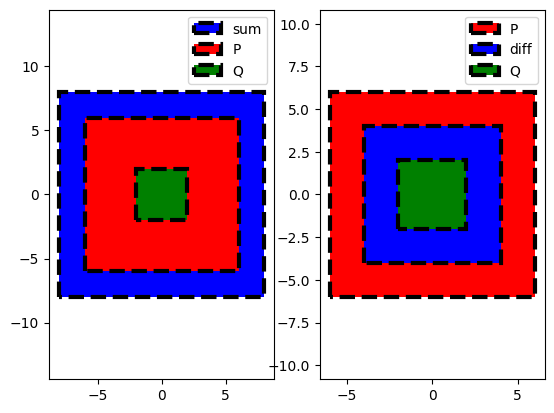

In [ ]:
# Figure 4.11 MPC book


P = np.array([[1, 0],
              [0, 1],
              [0, -1],
              [-1, 0]])

p = np.array([[6],
              [6],
              [6],
              [6]])

Q = np.array([[1, 0],
              [0, 1],
              [0, -1],
              [-1, 0]])

q = np.array([[2],
              [2],
              [2],
              [2]])

Pp = pt.Polytope(P, p)
Qq = pt.Polytope(Q, q)

p_sum  = minkowski_sum(Pp, Qq)
p_diff = pontryagin_diff(Pp, Qq)

fig, ax = plt.subplots(1,2)

p_sum.plot(ax[0], color='b')
Pp.plot(ax[0], color='r')
Qq.plot(ax[0], color='g')
ax[0].legend(['sum', 'P', 'Q'])
ax[0].autoscale_view()
ax[0].axis('equal')

Pp.plot(ax[1], color='r')
p_diff.plot(ax[1], color='b')
Qq.plot(ax[1], color='g')
ax[1].legend(['P', 'diff', 'Q'])
ax[1].autoscale_view()
ax[1].axis('equal')
plt.show()

## Example 2:

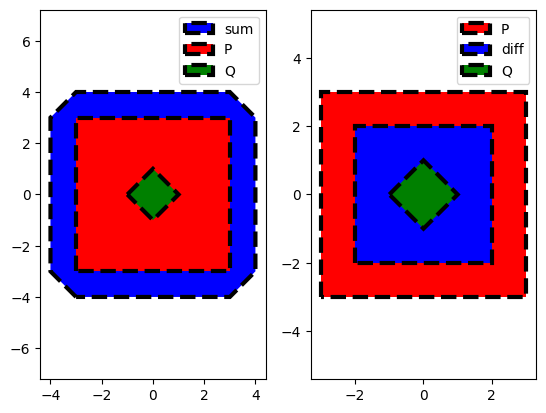

In [ ]:
# Figure 4.12 MPC book

P = np.array([[1, 0],
              [0, 1],
              [0, -1],
              [-1, 0]])

p = np.array([[3],
              [3],
              [3],
              [3]])

Q = np.array([[1, 1],
              [-1, 1],
              [1, -1],
              [-1, -1]])

q = np.array([[1],
              [1],
              [1],
              [1]])

Pp = pt.Polytope(P, p)
Qq = pt.Polytope(Q, q)

p_sum  = minkowski_sum(Pp, Qq)
p_diff = pontryagin_diff(Pp, Qq)

fig, ax = plt.subplots(1,2)

p_sum.plot(ax[0], color='b')
Pp.plot(ax[0], color='r')
Qq.plot(ax[0], color='g')
ax[0].legend(['sum', 'P', 'Q'])
ax[0].autoscale_view()
ax[0].axis('equal')

Pp.plot(ax[1], color='r')
p_diff.plot(ax[1], color='b')
Qq.plot(ax[1], color='g')
ax[1].legend(['P', 'diff', 'Q'])
ax[1].autoscale_view()
ax[1].axis('equal')
plt.show()

## Example 3:

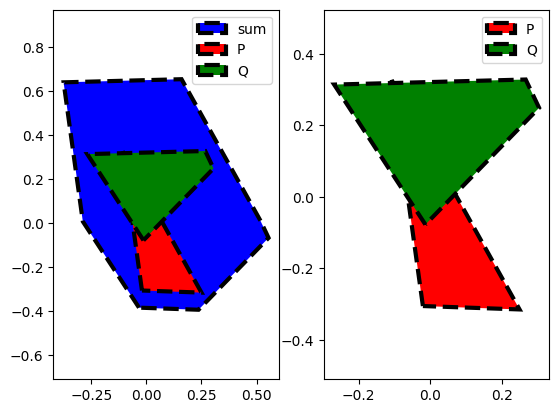

In [ ]:
P = np.array([[ 1.03082,  0.57476],
                [ 1.39843, -0.02453],
                [-0.09322, -0.6941 ],
                [-0.08384, -2.38547],
                [ 0.29675, -0.49254],
                [-2.25599, -0.31178],
                [-0.05872,  0.29463],
                [ 0.02283, -0.77105],
                [ 1.72335,  0.92748],
                [-0.10928,  0.6722 ]])

p = np.array([[0.07646],
               [0.93069],
               [0.71248],
               [0.73121],
               [0.38619],
               [0.1412 ],
               [0.74394],
               [0.50318],
               [0.78187],
               [0.52737]])

Q = np.array([[ 0.23464, -0.90068],
        [ 0.76585,  0.36301],
        [ 0.03942, -0.00125],
        [-0.93651, -0.61058],
        [-0.03155, -0.02491],
        [ 0.90742, -0.88392],
        [ 0.24336,  0.78635],
        [-0.0207 ,  0.78292],
        [ 0.45283, -0.43739],
        [ 0.28562, -1.13553]])

q = np.array([[0.59815],
                [0.32358],
                [0.82303],
                [0.06005],
                [0.13205],
                [0.0567 ],
                [0.95662],
                [0.25109],
                [0.39949],
                [0.57888]])

Pp = pt.Polytope(P, p)
Qq = pt.Polytope(Q, q)

p_sum  = minkowski_sum(Pp, Qq)
p_diff = pontryagin_diff(Pp, Qq)

fig, ax = plt.subplots(1,2)

p_sum.plot(ax[0], color='b')
Pp.plot(ax[0], color='r')
Qq.plot(ax[0], color='g')
ax[0].legend(['sum', 'P', 'Q'])
ax[0].autoscale_view()
ax[0].axis('equal')

if pt.is_empty(pt.reduce(p_diff)):
    Pp.plot(ax[1], color='r')
    Qq.plot(ax[1], color='g')
    ax[1].legend(['P', 'Q'])
else:
    Pp.plot(ax[1], color='r')
    p_diff.plot(ax[1], color='b')
    Qq.plot(ax[1], color='g')
    ax[1].legend(['P', 'diff', 'Q'])

ax[1].autoscale_view()
ax[1].axis('equal')
plt.show()

# Successor & Precursor operator
## Example 1: successor autonomous system

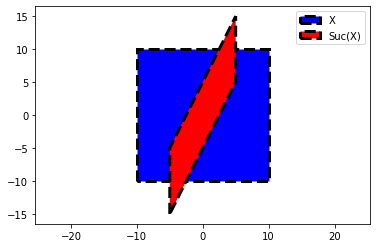

In [ ]:
# Example 10.1 (Figure 10.2) MPC book

A = np.array([[0.5, 0],
              [1.0, -0.5]])

X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[10.0],
                          [10.0],
                          [10.0],
                          [10.0]]))
sucp = successor(X, A)
fig, ax = plt.subplots()
X.plot(ax, color='b')
sucp.plot(ax, color='r')
ax.legend(['X', 'Suc(X)'])
ax.autoscale_view()
ax.axis('equal')
plt.show()

## Example 2: successor controlled system

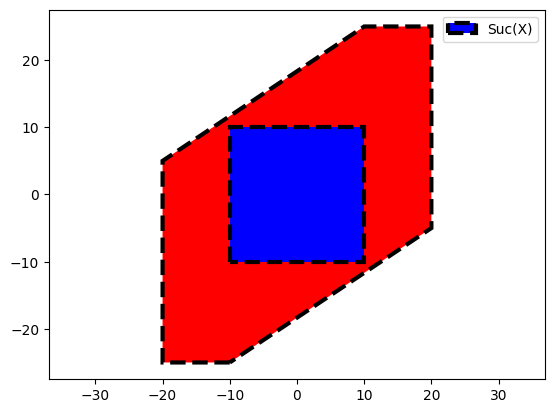

In [ ]:
# Example 10.2 (Figure 10.4) MPC book

A = np.array([[1.5, 0],
              [1.0, -1.5]])

B = np.array([[1.0],
              [0.0]])
X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[10.0],
                          [10.0],
                          [10.0],
                          [10.0]]))

U = pt.Polytope(np.array([[1.0],
                          [-1.0]]),
                np.array([[5.0],
                          [5.0]]))
sucp = successor(X, A, U, B)
fig, ax = plt.subplots()
X.plot(ax, color='b')
sucp.plot(ax, color='r')
X.plot(ax, color='b')
ax.legend(['Suc(X)'])
ax.autoscale_view()
ax.axis('equal')
plt.show()

## Example 3: precursor autonomous system

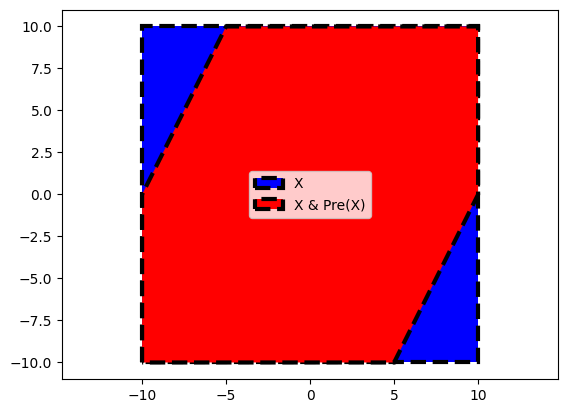

In [ ]:
# Example 10.1 (Figure 10.1) MPC book

A = np.array([[0.5, 0],
              [1.0, -0.5]])

X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[10.0],
                          [10.0],
                          [10.0],
                          [10.0]]))
prep = precursor(X, A)
fig, ax = plt.subplots()
X.plot(ax, color='b')
prep.intersect(X).plot(ax, color='r')
ax.legend(['X', 'X & Pre(X)'])
ax.autoscale_view()
ax.axis('equal')
plt.show()

## Example 4: precursor controlled system

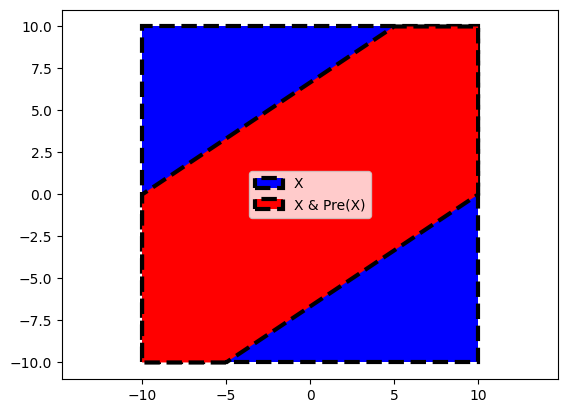

In [ ]:
# Example 10.2 (Figure 10.3) MPC book

A = np.array([[1.5, 0],
              [1.0, -1.5]])

B = np.array([[1.0],
              [0.0]])
X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[10.0],
                          [10.0],
                          [10.0],
                          [10.0]]))

U = pt.Polytope(np.array([[1.0],
                          [-1.0]]),
                np.array([[5.0],
                          [5.0]]))

prep = precursor(X, A, U, B)
fig, ax = plt.subplots()
X.plot(ax, color='b')
prep.intersect(X).plot(ax, color='r')
ax.legend(['X', 'X & Pre(X)'])
ax.autoscale_view()
ax.axis('equal')
plt.show()

# Maximal & Control positive invariant set
## Example 1: $\mathcal{O}_{\infty}$

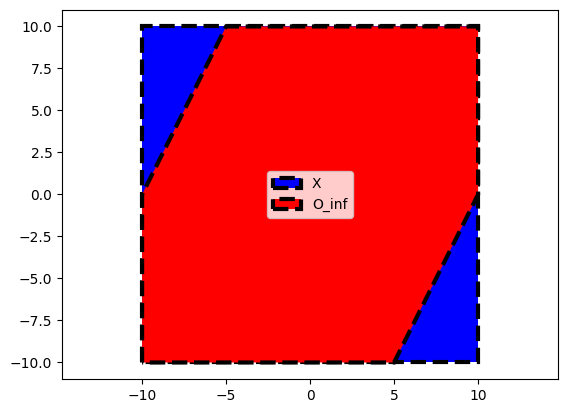

In [ ]:
# Example 10.5 (Figure 10.7) MPC book

A = np.array([[0.5, 0],
              [1.0, -0.5]])

X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[10.0],
                          [10.0],
                          [10.0],
                          [10.0]]))
Oinfset = Oinf(X, A)
fig, ax = plt.subplots()
X.plot(ax, color='b')
Oinfset.plot(ax, color='r')
ax.legend(['X', 'O_inf'])
ax.autoscale_view()
ax.axis('equal')
plt.show()

## Example 2: $\mathcal{C}_{\infty}$

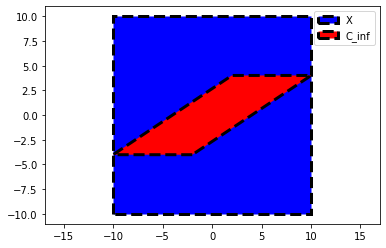

In [ ]:
# Example 10.6 (Figure 10.8) MPC book

A = np.array([[1.5, 0],
              [1.0, -1.5]])

B = np.array([[1.0],
              [0.0]])
X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[10.0],
                          [10.0],
                          [10.0],
                          [10.0]]))

U = pt.Polytope(np.array([[1.0],
                          [-1.0]]),
                np.array([[5.0],
                          [5.0]]))

Cinfset = Cinf(X, A, U, B)
fig, ax = plt.subplots()
X.plot(ax, color='b')
Cinfset.plot(ax, color='r')
ax.legend(['X', 'C_inf'])
ax.autoscale_view()
ax.axis('equal')
plt.show()

# Models with additive uncertainty
## Example 1:

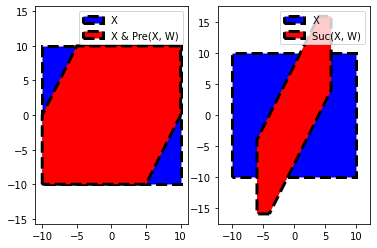

In [ ]:
# Example 10.8 (Figures 10.9 and 10.10) MPC book

A = np.array([[0.5, 0],
              [1.0, -0.5]])

X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[10.0],
                          [10.0],
                          [10.0],
                          [10.0]]))

W = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[1.0],
                          [1.0],
                          [1.0],
                          [1.0]]))

prep = precursor(X, A, Wset=W)
fig, ax = plt.subplots(1,2)
X.plot(ax[0], color='b')
prep.intersect(X).plot(ax[0], color='r')
ax[0].legend(['X', 'X & Pre(X, W)'])
ax[0].autoscale_view()
ax[0].axis('equal')

sucp = successor(X, A, Wset=W)
X.plot(ax[1], color='b')
sucp.plot(ax[1], color='r')
ax[1].legend(['X', 'Suc(X, W)'])
ax[1].autoscale_view()
ax[1].axis('equal')
plt.show()

## Example 2:

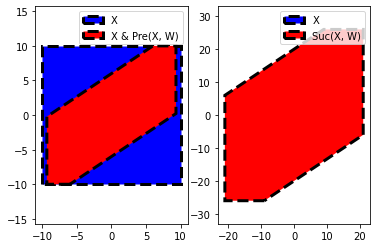

In [ ]:
A = np.array([[1.5, 0],
              [1.0, -1.5]])
B = np.array([[1.0],
              [0.0]])

X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[10.0],
                          [10.0],
                          [10.0],
                          [10.0]]))

U = pt.Polytope(np.array([[1.0],
                          [-1.0]]),
                np.array([[5.0],
                          [5.0]]))

W = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[1.0],
                          [1.0],
                          [1.0],
                          [1.0]]))

prep = precursor(X, A, Uset=U, B=B, Wset=W)
fig, ax = plt.subplots(1,2)
X.plot(ax[0], color='b')
prep.intersect(X).plot(ax[0], color='r')
ax[0].legend(['X', 'X & Pre(X, W)'])
ax[0].autoscale_view()
ax[0].axis('equal')

sucp = successor(X, A, Uset=U, B=B, Wset=W)
X.plot(ax[1], color='b')
sucp.plot(ax[1], color='r')
ax[1].legend(['X', 'Suc(X, W)'])
ax[1].autoscale_view()
ax[1].axis('equal')
plt.show()

# Robust invariant set
## Example 1: $\mathcal{O}_{\infty}$

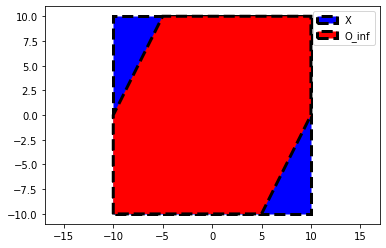

In [ ]:
A = np.array([[0.5, 0],
              [1.0, -0.5]])

X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[10.0],
                          [10.0],
                          [10.0],
                          [10.0]]))

W = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[1.0],
                          [1.0],
                          [1.0],
                          [1.0]]))

Oinfset = Oinf(X, A, Wset=W)
fig, ax = plt.subplots()
X.plot(ax, color='b')
Oinfset.plot(ax, color='r')
ax.legend(['X', 'O_inf'])
ax.autoscale_view()
ax.axis('equal')
plt.show()

## Example 2: $\mathcal{C}_{\infty}$

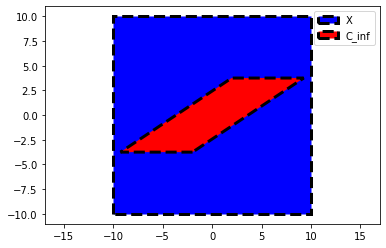

In [ ]:
A = np.array([[1.5, 0],
              [1.0, -1.5]])

B = np.array([[1.0],
              [0.0]])
X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[10.0],
                          [10.0],
                          [10.0],
                          [10.0]]))

U = pt.Polytope(np.array([[1.0],
                          [-1.0]]),
                np.array([[5.0],
                          [5.0]]))

W = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[0.1],
                          [0.1],
                          [0.1],
                          [0.1]]))

Cinfset = Cinf(X, A, U, B, Wset=W)
fig, ax = plt.subplots()
X.plot(ax, color='b')
Cinfset.plot(ax, color='r')
ax.legend(['X', 'C_inf'])
ax.autoscale_view()
ax.axis('equal')
plt.show()